In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2
from math import exp

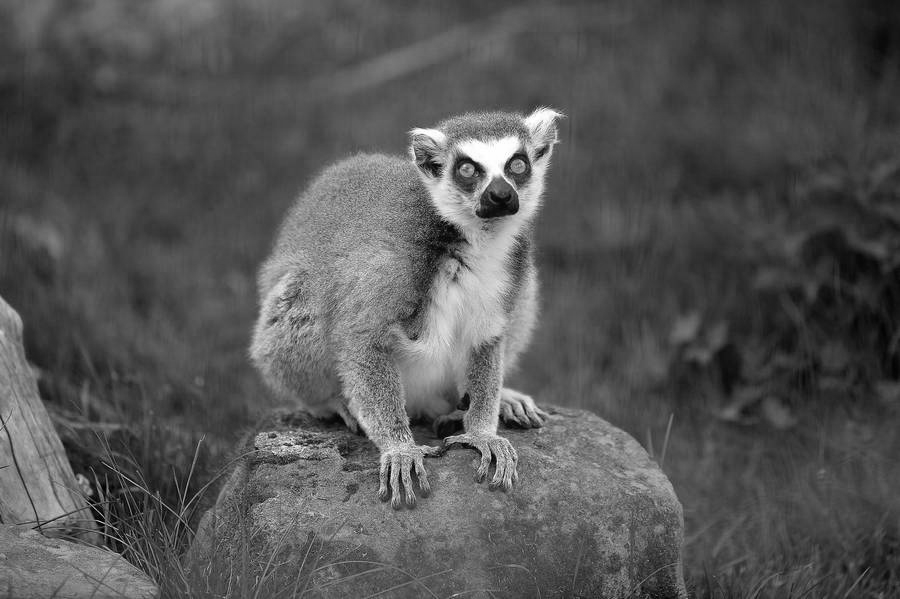

In [67]:
image = Image.open("lemur.jpg")


tensor = transforms.ToTensor()(image)

# use convolution to transform image to grayscale
conv = nn.Conv2d(3, 1, kernel_size=1, stride=1, padding=0, bias=False)
conv.weight = nn.Parameter(torch.ones(1, 3, 1, 1) / 3)
grayscale = conv(tensor.unsqueeze(0)).squeeze(0)

# display grayscale image
grayscale_image = transforms.ToPILImage()(grayscale)

# save grayscale image
grayscale_image.save("report/images/lemur_grayscale.png")
grayscale_image

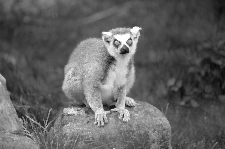

In [74]:
# transform grayscale using pooling
pool = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
# pool = nn.AvgPool2d(kernel_size=4, stride=4, padding=0)
pooled = pool(grayscale.unsqueeze(0)).squeeze(0)

# save pooled image
pooled_image = transforms.ToPILImage()(pool(grayscale.unsqueeze(0)).squeeze(0))
pooled_image.save("report/images/lemur_pooled.png")

# display pooled image
pooled_image

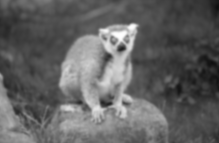

In [101]:
def gauss_kernel(size, sigma=1):
    kernel = torch.zeros(1, 1, size, size)
    half_size = size // 2
    double_sigma_sq = 2 * sigma**2
    for i in range(size):
        for j in range(size):
            kernel[0, 0, i, j] = exp(
                -((i - half_size) ** 2 + (j - half_size) ** 2) \
                    / (double_sigma_sq)
            )
    return kernel / kernel.sum()

kernel_size = 7

gk = gauss_kernel(kernel_size, 1)
conv = nn.Conv2d(1, 1, kernel_size=kernel_size, stride=1, bias=False)
conv.weight = nn.Parameter(gk)
gauss = conv(pooled.unsqueeze(0)).squeeze(0)

gauss_image = transforms.ToPILImage()(gauss)
gauss_image.save("report/images/lemur_gauss.png")
gauss_image

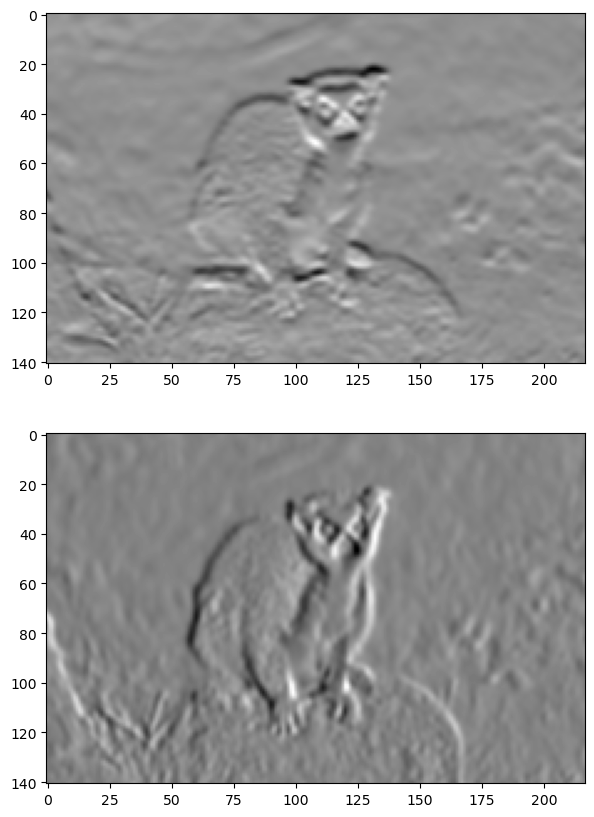

In [103]:
sob_vert = torch.FloatTensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
sob_hori = torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

conv = nn.Conv2d(1, 2, kernel_size=3, stride=1, bias=False)
conv.weight = nn.Parameter(torch.stack([sob_vert.unsqueeze(0), sob_hori.unsqueeze(0)]))
sobel = conv(gauss.unsqueeze(0)).squeeze(0)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].imshow(sobel[0].detach().numpy(), cmap='gray')
ax[1].imshow(sobel[1].detach().numpy(), cmap='gray')

fig.savefig("report/images/lemur_sobel.png")

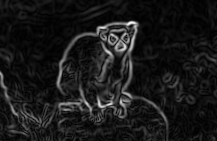

In [106]:
squared = sobel ** 2

# sum the two channels
conv = nn.Conv2d(2, 1, kernel_size=1, stride=1, padding=0, bias=False)
conv.weight = nn.Parameter(torch.ones(1, 2, 1, 1))
intensity = conv(squared.unsqueeze(0)).squeeze(0) ** 0.5

intensity_image = transforms.ToPILImage()(intensity/ intensity.max())
intensity_image.save("report/images/lemur_intensity.png")
intensity_image


<class 'torch.Tensor'>


/home/mjste/miniconda3/envs/mro/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


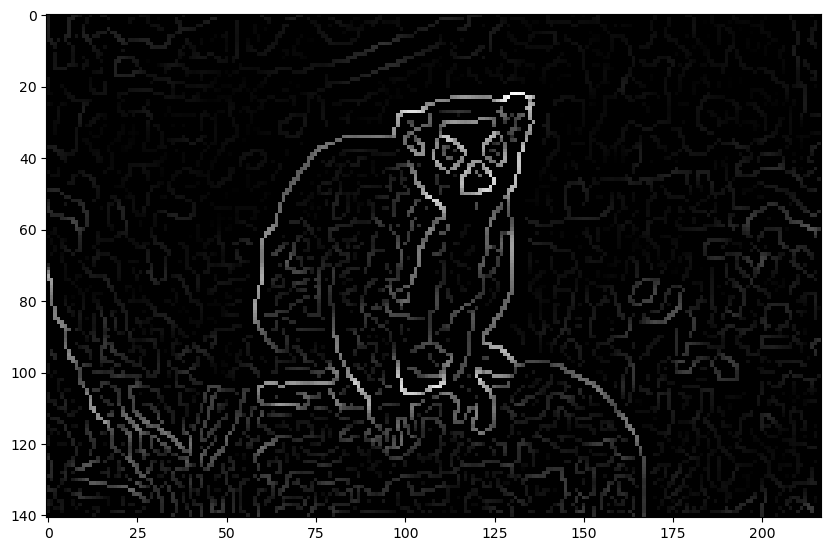

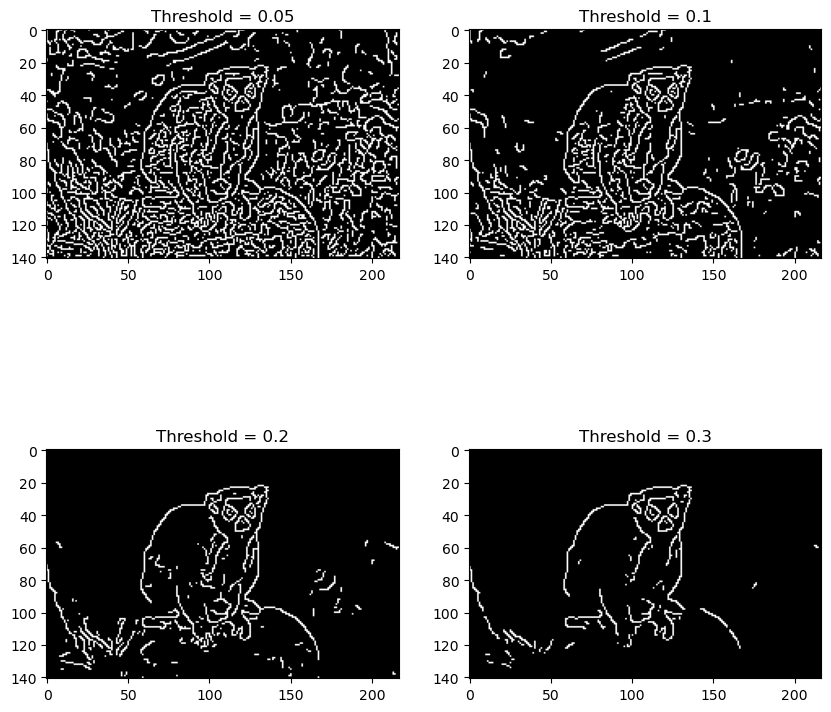

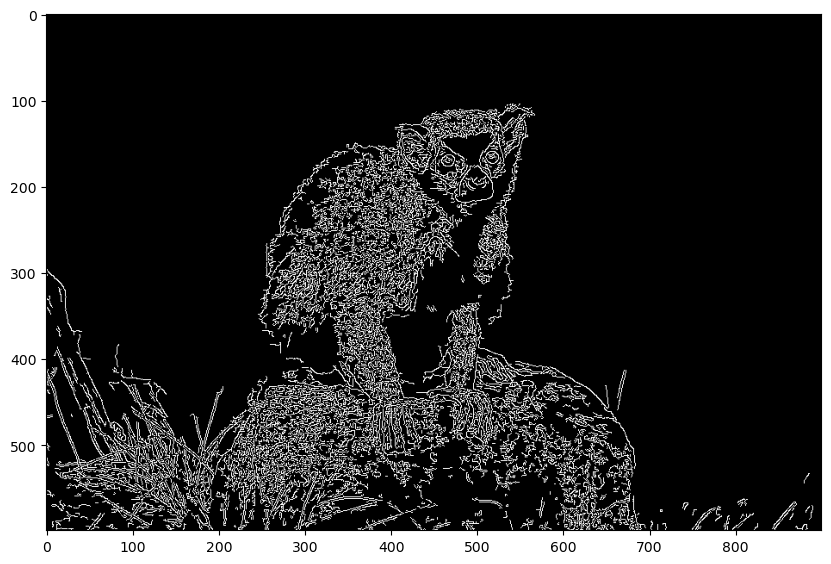

In [112]:
angles = torch.atan2(sobel[0], sobel[1]) * 180 / torch.pi
angles[angles < 0] += 180

def non_max_supression(intensity, angle):
    assert intensity.shape == angle.shape
    assert intensity.dim() == 2

    max_intensity = intensity.max()
    height, width = intensity.shape

    # create output tensor
    output = torch.zeros(height, width)

    for i in range(height):
        for j in range(width):

            try:
                a = max_intensity
                b = max_intensity
                # 0 degrees
                current_angle = angle[i, j]
                if current_angle < 22.5 or current_angle > 157.5:
                    a = intensity[i, j + 1]
                    b = intensity[i, j - 1]
                # 45 degrees
                elif 22.5 < current_angle < 67.5:
                    a = intensity[i + 1, j + 1]
                    b = intensity[i - 1, j - 1]
                # 90 degrees
                elif 67.5 < current_angle < 112.5:
                    a = intensity[i + 1, j]
                    b = intensity[i - 1, j]
                # 135 degrees
                elif 112.5 < current_angle < 157.5:
                    a = intensity[i - 1, j + 1]
                    b = intensity[i + 1, j - 1]

                if intensity[i, j] >= a and intensity[i, j] >= b:
                    output[i, j] = intensity[i, j]

            except IndexError:
                pass
    return output / output.max()

non_max = non_max_supression(intensity[0], angles)
non_max_image = transforms.ToPILImage()(non_max)
non_max_image.save("report/images/lemur_non_max.png")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(non_max_image, cmap='gray')

def threshold_image(input, threshold):
    return (input > threshold).float()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(threshold_image(non_max, 0.05).detach().numpy(), cmap='gray')
ax[0, 0].set_title("Threshold = 0.05")
ax[0, 1].imshow(threshold_image(non_max, 0.1).detach().numpy(), cmap='gray')
ax[0, 1].set_title("Threshold = 0.1")
ax[1, 0].imshow(threshold_image(non_max, 0.2).detach().numpy(), cmap='gray')
ax[1, 0].set_title("Threshold = 0.2")
ax[1, 1].imshow(threshold_image(non_max, 0.3).detach().numpy(), cmap='gray')
ax[1, 1].set_title("Threshold = 0.3")

fig.savefig("report/images/lemur_threshold.png")

edge_tensor = threshold_image(non_max, 0.15)
print(type(edge_tensor))
edge_image = transforms.functional.resize(edge_tensor.unsqueeze(0), size=(image.height, image.width), interpolation=Image.BILINEAR)
transforms.ToPILImage()(edge_image)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(edge_image.squeeze(0).detach().numpy(), cmap='gray')



canny = cv2.Canny(np.array(image), 100, 200)
plt.imshow(canny, cmap='gray')


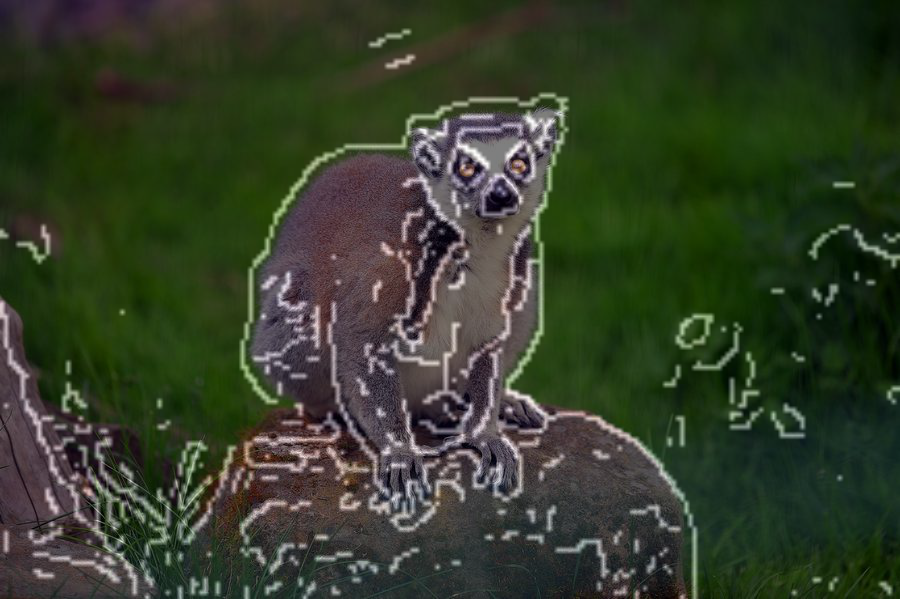

In [113]:
result_image = transforms.ToPILImage()((edge_image + tensor)/2)
result_image.save("report/images/lemur_result.png")
result_image

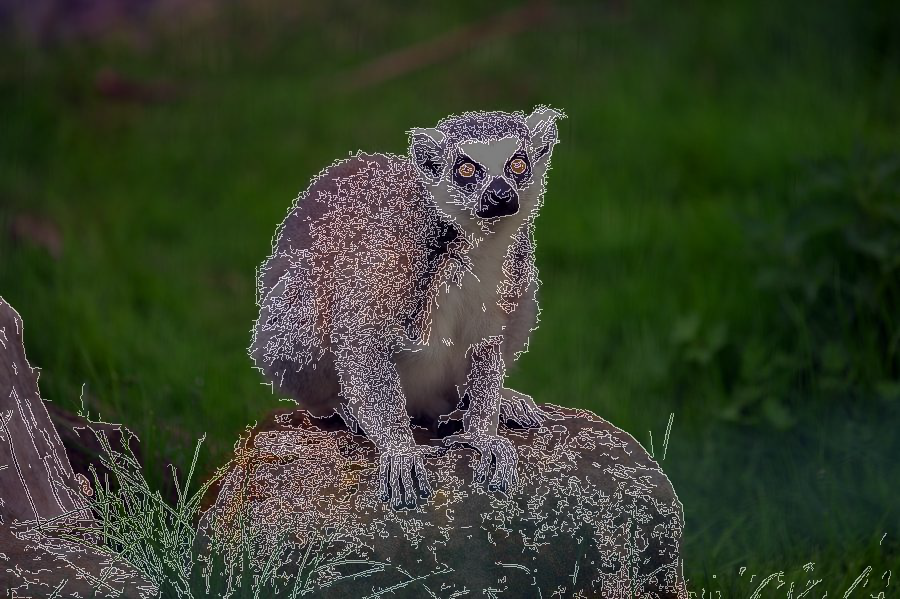

In [115]:
# add canny to tensor
canny_tensor = (torch.FloatTensor(canny) / 255)
cv_image = transforms.ToPILImage()((canny_tensor+ tensor)/2)
cv_image.save("report/images/lemur_cv.png")
cv_image